# Early Count Analysis

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Watermark" data-toc-modified-id="Watermark-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Watermark</a></span></li><li><span><a href="#File-locations" data-toc-modified-id="File-locations-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>File locations</a></span></li><li><span><a href="#Plotting-stuff" data-toc-modified-id="Plotting-stuff-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting stuff</a></span></li></ul></li><li><span><a href="#Get-data" data-toc-modified-id="Get-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get data</a></span><ul class="toc-item"><li><span><a href="#AEC-Enrolment-data" data-toc-modified-id="AEC-Enrolment-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>AEC Enrolment data</a></span></li><li><span><a href="#Latest-AEC-national-count-data" data-toc-modified-id="Latest-AEC-national-count-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Latest AEC national count data</a></span><ul class="toc-item"><li><span><a href="#First-preference-votes-nationally" data-toc-modified-id="First-preference-votes-nationally-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>First preference votes nationally</a></span></li><li><span><a href="#First-preferences-by-Division" data-toc-modified-id="First-preferences-by-Division-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>First preferences by Division</a></span></li><li><span><a href="#First-preference-by-state" data-toc-modified-id="First-preference-by-state-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>First preference by state</a></span></li><li><span><a href="#Two-party-preferred-votes-by-state" data-toc-modified-id="Two-party-preferred-votes-by-state-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>Two party preferred votes by state</a></span></li><li><span><a href="#Two-Party-Preferred-by-Division" data-toc-modified-id="Two-Party-Preferred-by-Division-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>Two Party Preferred by Division</a></span></li><li><span><a href="#Two-candidate-preferred-by-Division" data-toc-modified-id="Two-candidate-preferred-by-Division-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>Two candidate preferred by Division</a></span></li></ul></li></ul></li><li><span><a href="#Data-consistency-checks" data-toc-modified-id="Data-consistency-checks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data consistency checks</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#State-2pp-swings" data-toc-modified-id="State-2pp-swings-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>State 2pp swings</a></span></li><li><span><a href="#State-primary-first-preference-swings" data-toc-modified-id="State-primary-first-preference-swings-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>State primary first preference swings</a></span></li><li><span><a href="#Divisional-2pp-swings" data-toc-modified-id="Divisional-2pp-swings-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Divisional 2pp swings</a></span></li><li><span><a href="#Green-TCP-swings" data-toc-modified-id="Green-TCP-swings-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Green TCP swings</a></span></li><li><span><a href="#Traditional-TCP-swings" data-toc-modified-id="Traditional-TCP-swings-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Traditional TCP swings</a></span></li></ul></li><li><span><a href="#Seat-allocations" data-toc-modified-id="Seat-allocations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Seat allocations</a></span><ul class="toc-item"><li><span><a href="#Tally-Class" data-toc-modified-id="Tally-Class-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Tally Class</a></span></li><li><span><a href="#Get-status-of-individual-seats" data-toc-modified-id="Get-status-of-individual-seats-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Get status of individual seats</a></span></li><li><span><a href="#Thresholds-for-counting-purposes" data-toc-modified-id="Thresholds-for-counting-purposes-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Thresholds for counting purposes</a></span></li><li><span><a href="#Initialise-tally---apply-any-manual-blocks" data-toc-modified-id="Initialise-tally---apply-any-manual-blocks-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Initialise tally - apply any manual blocks</a></span></li><li><span><a href="#Do-the-declared-seats" data-toc-modified-id="Do-the-declared-seats-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Do the declared seats</a></span></li><li><span><a href="#Ugly-manual-adjustments" data-toc-modified-id="Ugly-manual-adjustments-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Ugly manual adjustments</a></span></li><li><span><a href="#First-Preferences" data-toc-modified-id="First-Preferences-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>First Preferences</a></span></li><li><span><a href="#TCP-counts" data-toc-modified-id="TCP-counts-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>TCP counts</a></span></li><li><span><a href="#State-of-play" data-toc-modified-id="State-of-play-5.9"><span class="toc-item-num">5.9&nbsp;&nbsp;</span>State of play</a></span></li><li><span><a href="#State-of-the-House" data-toc-modified-id="State-of-the-House-5.10"><span class="toc-item-num">5.10&nbsp;&nbsp;</span>State of the House</a></span></li><li><span><a href="#House-outcome-and-closer-seats" data-toc-modified-id="House-outcome-and-closer-seats-5.11"><span class="toc-item-num">5.11&nbsp;&nbsp;</span>House outcome and closer seats</a></span></li><li><span><a href="#Hypothetically-allocate-remainders-by-hand" data-toc-modified-id="Hypothetically-allocate-remainders-by-hand-5.12"><span class="toc-item-num">5.12&nbsp;&nbsp;</span>Hypothetically allocate remainders by hand</a></span></li></ul></li><li><span><a href="#The-End" data-toc-modified-id="The-End-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

### Imports

In [1]:
# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch

# system imports
from pathlib import Path
import itertools
import numbers
import math
from datetime import datetime
from typing import Any, Union, Iterable, Optional, List, Dict
from copy import deepcopy


# local imports
import common

### Watermark

In [2]:
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Sun May 29 2022 13:15:28

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2

Watermark: 2.3.1



### File locations

In [3]:
# path to the model data 
PUBLIC_DATA_DIR = '../data/'
Path(PUBLIC_DATA_DIR).mkdir(parents=True, exist_ok=True)

PRIVATE_DATA_DIR = '../historical-data/'
Path(PRIVATE_DATA_DIR).mkdir(parents=True, exist_ok=True)

CHARTS_DIR = '../charts/'
Path(CHARTS_DIR).mkdir(parents=True, exist_ok=True)

### Plotting stuff

In [4]:
# plotting stuff
plt.style.use('./markgraph.mplstyle')
LFOOTER = f'Election data from AEC {datetime.now().now().strftime("%d/%m/%Y %H:%M")}. '
LFOOTER

'Election data from AEC 29/05/2022 13:15. '

## Get data

### AEC Enrolment data

In [5]:
enrolmentByDiv = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'GeneralEnrolmentByDivisionDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
enrolmentByDiv.index = enrolmentByDiv['DivisionNm']

enrolment_div = enrolmentByDiv.Enrolment
enrolment_state = enrolmentByDiv.groupby('StateAb').sum().Enrolment

### Latest AEC national count data

#### First preference votes nationally

In [6]:
houseFirstPrefsByParty = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseFirstPrefsByPartyDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)
houseFirstPrefsByParty = houseFirstPrefsByParty.set_index(['PartyAb'], drop=True)
houseFirstPrefsByParty.columns

Index(['PartyNm', 'OrderOfAppearance', 'Contested', 'Nominations', 'Elected',
       'OrdinaryVotes', 'OrdinaryPercentage', 'AbsentVotes',
       'AbsentPercentage', 'ProvisionalVotes', 'ProvisionalPercentage',
       'PrePollVotes', 'PrePollPercentage', 'PostalVotes', 'PostalPercentage',
       'TotalVotes', 'TotalPercentage', 'TotalSwing'],
      dtype='object')

In [7]:
# Party groupings
groups = {
    'Coalition': ['LP', 'LNP', 'NP', 'CLP'],
    'Labor': ['ALP'],
    'Green': ['GRN'],
    'One Nation': ['ON'],
    'UAP': ['UAPP'],
}
groups['Other'] = (
    list(set(houseFirstPrefsByParty.index.to_list()) 
         - set(itertools.chain.from_iterable(groups.values())))
)

In [8]:
def get_group_totals(data):
    total_votes = data['TotalVotes'].sum()
    primary_tally = {}
    for label, group in groups.items():
        both = list(set(group).intersection(set(data.index)))
        primary_tally[label] = (
            data
            .loc[both, 'TotalVotes']
            .sum() 
            / total_votes * 100
        )
    return pd.Series(primary_tally)

In [9]:
# current state of primary votes
primary_tally = get_group_totals(houseFirstPrefsByParty)
primary_tally

Coalition     36.172544
Labor         32.780813
Green         11.742017
One Nation     4.852185
UAP            4.070718
Other         10.381723
dtype: float64

#### First preferences by Division

In [10]:
houseFirstPrefsByCandidate = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
print(houseFirstPrefsByCandidate.TotalVotes.sum())
print(houseFirstPrefsByCandidate.columns)
fp_by_div = pd.pivot_table(houseFirstPrefsByCandidate, index='DivisionNm', 
                           columns='PartyAb', 
                           values='TotalVotes', aggfunc=pd.Series.sum)
fp_by_div.shape

13541174
Index(['StateAb', 'DivisionID', 'DivisionNm', 'CandidateID', 'Surname',
       'GivenNm', 'BallotPosition', 'Elected', 'HistoricElected', 'PartyAb',
       'PartyNm', 'OrdinaryVotes', 'AbsentVotes', 'ProvisionalVotes',
       'PrePollVotes', 'PostalVotes', 'TotalVotes', 'Swing'],
      dtype='object')


(151, 36)

In [11]:
assert not fp_by_div.columns.has_duplicates

In [12]:
fp_by_div.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,38302.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,718.0,NaN,NaN,NaN,18670.0,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,27912.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9938.0,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,37123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,569.0,NaN,NaN,NaN,11582.0,NaN,NaN,NaN,1625.0,NaN,NaN
Banks,NaN,28979.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6864.0,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,20052.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,679.0,NaN,NaN,NaN,6829.0,NaN,NaN,NaN,4605.0,NaN,NaN
Barton,NaN,39954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9329.0,NaN,NaN,NaN,NaN,NaN,NaN
Bass,851.0,17878.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6722.0,NaN,NaN,NaN,3085.0,4071.0,NaN
Bean,NaN,38869.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13395.0,NaN,NaN,NaN,7592.0,NaN,NaN
Bendigo,NaN,39676.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12307.0,NaN,NaN,NaN,3871.0,NaN,NaN


In [13]:
# the least counted
fp_count_pct = fp_by_div.sum(axis=1) / enrolment_div * 100
fp_count_pct.sort_values().head()

DivisionNm
Lingiari     58.185010
Durack       59.026805
Melbourne    61.348048
Blaxland     64.813504
O'Connor     65.292402
dtype: float64

In [14]:
# the most counted
fp_count_pct.sort_values().tail()

DivisionNm
Deakin      82.991234
Franklin    83.306569
Calare      83.416143
Cook        83.757127
Bean        84.493004
dtype: float64

In [15]:
fp_vote_pct = (fp_by_div.div(fp_by_div.sum(axis=1), axis=0) * 100).round(2)
fp_vote_pct.iloc[0:10, 0:20]

PartyAb,AJP,ALP,ASP,AUC,AUD,AUP,AUVA,CEC,CLP,CYA,DHJP,DPDA,GAP,GRN,HMP,IAP,IMO,IND,JLN,KAP
DivisionNm,,,,,,,,,,,,,,,,,,,,
Adelaide,NaN,40.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.76,NaN,NaN,NaN,19.70,NaN,NaN,NaN,NaN,NaN,NaN
Aston,NaN,32.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.65,NaN,NaN,NaN,NaN,NaN,NaN
Ballarat,NaN,45.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,14.14,NaN,NaN,NaN,1.98,NaN,NaN
Banks,NaN,35.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.35,NaN,NaN,NaN,NaN,NaN,NaN
Barker,NaN,20.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,NaN,7.12,NaN,NaN,NaN,4.80,NaN,NaN
Barton,NaN,51.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.92,NaN,NaN,NaN,NaN,NaN,NaN
Bass,1.38,28.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.87,NaN,NaN,NaN,4.99,6.58,NaN
Bean,NaN,41.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.47,NaN,NaN,NaN,8.20,NaN,NaN
Bendigo,NaN,43.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.49,NaN,NaN,NaN,4.24,NaN,NaN


#### First preference by state 

In [16]:
houseFirstPrefsByStateByParty2022 = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseFirstPrefsByStateByPartyDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2022 = houseFirstPrefsByStateByParty2022.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2019 = (
    pd.read_csv('https://results.aec.gov.au/24310/Website/'
                'Downloads/HouseFirstPrefsByStateByPartyDownload-24310.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseFirstPrefsByStateByParty2019 = houseFirstPrefsByStateByParty2019.set_index(['PartyAb'], drop=True)

houseFirstPrefsByStateByParty2022

,StateAb,PartyNm,OrderOfAppearance,Contested,Nominations,Elected,OrdinaryVotes,OrdinaryPercentage,AbsentVotes,AbsentPercentage,ProvisionalVotes,ProvisionalPercentage,DeclarationPrePollVotes,DeclarationPrePollPercentage,PostalVotes,PostalPercentage,TotalVotes,TotalPercentage,TotalSwing
PartyAb,,,,,,,,,,,,,,,,,,,
LP,NSW,Liberal,1,38,38,0,1061702,27.79,895,28.58,0,0.0,187,22.58,117337,36.41,1180121,28.46,-4.33
NP,NSW,The Nationals,2,9,9,0,335222,8.77,0,0.00,0,0.0,0,0.00,20420,6.34,355642,8.58,-1.18
ALP,NSW,Australian Labor Party,3,47,47,0,1279754,33.50,1082,34.55,0,0.0,337,40.70,104837,32.53,1386010,33.42,-1.14
UAPP,NSW,United Australia Party,4,47,47,0,152405,3.99,164,5.24,0,0.0,22,2.66,8171,2.54,160762,3.88,0.50
IND,NSW,Independent,5,27,37,0,296637,7.76,23,0.73,0,0.0,25,3.02,20914,6.49,317599,7.66,3.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LDP,NT,Liberal Democratic Party,4,2,2,0,6408,7.32,169,9.66,0,0.0,0,0.00,360,8.49,6937,7.42,7.42
ON,NT,Pauline Hanson's One Nation,5,2,2,0,4504,5.15,118,6.74,0,0.0,0,0.00,267,6.30,4889,5.23,5.23
UAPP,NT,United Australia Party,6,2,2,0,3889,4.44,115,6.57,0,0.0,0,0.00,113,2.67,4117,4.40,1.55


#### Two party preferred votes by state

In [17]:
houseTppByState = pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                                       'HouseTppByStateDownload-27966.txt',
                                       header=1, sep='\t',  skipinitialspace=True)

# State name as index - add percent counted to the data
houseTppByState.index = houseTppByState['StateAb']
houseTppByState['Enrolment'] = enrolment_state
houseTppByState['Counted%'] =  houseTppByState['TotalVotes'] / houseTppByState['Enrolment']* 100.0
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1604428,48.72,1688402,51.28,3292830,-3.06,5472469,60.170830
VIC,VIC,Victoria,1169511,45.32,1411230,54.68,2580741,-1.54,4344208,59.406479
QLD,QLD,Queensland,1201591,54.96,984687,45.04,2186278,-3.48,3503609,62.400742
WA,WA,Western Australia,510550,44.46,637696,55.54,1148246,-11.09,1773969,64.727512
SA,SA,South Australia,383007,45.79,453475,54.21,836482,-3.50,1272047,65.758734
TAS,TAS,Tasmania,129461,48.96,134948,51.04,264409,4.92,402331,65.719271
ACT,ACT,Australian Capital Territory,63217,35.58,114476,64.42,177693,-2.81,314329,56.530896
NT,NT,Northern Territory,41281,44.14,52233,55.86,93514,-1.66,145938,64.077896


In [18]:
labor_tpp_election = (
    houseTppByState['Australian Labor Party Votes'].sum()
    / (houseTppByState['Australian Labor Party Votes'].sum()
       + houseTppByState['Liberal/National Coalition Votes'].sum())
    * 100
)

labor_tpp_election

51.76793088746112

#### Two Party Preferred by Division

In [19]:
houseTppByDivision = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTppByDivisionDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTppByDivision.index = houseTppByDivision['DivisionNm']
houseTppByDivision['Enrolment'] = enrolment_div
houseTppByDivision['Counted%'] =  houseTppByDivision['TotalVotes'] / houseTppByDivision['Enrolment']* 100.0

# IMPORTANT -- How many electorates are missing TPP vote data
houseTppByDivision[(houseTppByDivision['Counted%'] == 0.0)]

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
DivisionNm,,,,,,,,,,,,
Bradfield,Bradfield,108,NSW,NaN,0,0.0,0,0.0,0,-66.56,108573,0.0
Brisbane,Brisbane,156,QLD,NaN,0,0.0,0,0.0,0,-54.92,125241,0.0
Calare,Calare,109,NSW,NaN,0,0.0,0,0.0,0,-63.29,121564,0.0
Canberra,Canberra,101,ACT,NaN,0,0.0,0,0.0,0,-32.92,102196,0.0
Clark,Clark,319,TAS,NaN,0,0.0,0,0.0,0,-33.83,74797,0.0
Cooper,Cooper,320,VIC,NaN,0,0.0,0,0.0,0,-23.79,108730,0.0
Cowper,Cowper,113,NSW,NaN,0,0.0,0,0.0,0,-61.88,129887,0.0
Curtin,Curtin,238,WA,NaN,0,0.0,0,0.0,0,-63.95,119397,0.0
Fowler,Fowler,119,NSW,NaN,0,0.0,0,0.0,0,-36.01,108517,0.0


In [20]:
# make a more useful index
houseTppByDivision.index = (
    houseTppByDivision['DivisionNm'] + ' (' + 
    houseTppByDivision['StateAb'] + ')'
)
houseTppByDivision.head()

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,36176,38.18,58577,61.82,94753,-3.64,130151,72.802360
Aston (VIC),Aston,197,VIC,NaN,44883,53.18,39523,46.82,84406,-6.95,109826,76.854297
Ballarat (VIC),Ballarat,198,VIC,NaN,30160,36.82,51751,63.18,81911,-2.95,110704,73.991003
Banks (NSW),Banks,103,NSW,NaN,44144,53.68,38095,46.32,82239,-2.58,107786,76.298406
Barker (SA),Barker,180,SA,NaN,64014,66.76,31870,33.24,95884,-2.18,123518,77.627552


In [21]:
# How many seats are missing a TPP count
len(houseTppByDivision[
    (houseTppByDivision['Liberal/National Coalition Votes'] == 0)
    & (houseTppByDivision['Australian Labor Party Votes'] == 0)
])

26

#### Two candidate preferred by Division

In [22]:
houseTcp = (
    pd.read_csv('https://tallyroom.aec.gov.au/Downloads/'
                'HouseTcpByCandidateByVoteTypeDownload-27966.txt',
                header=1, sep='\t',  skipinitialspace=True)
)
houseTcp.head()

,StateAb,DivisionID,DivisionNm,CandidateID,Surname,GivenNm,BallotPosition,Elected,HistoricElected,PartyAb,PartyNm,OrdinaryVotes,AbsentVotes,ProvisionalVotes,PrePollVotes,PostalVotes,TotalVotes,Swing
0,ACT,318,Bean,36231,SMITH,David,3,N,Y,ALP,Australian Labor Party,53584,0,0,0,4763,58347,5.51
1,ACT,318,Bean,37198,HIATT,Jane,6,N,N,LP,Liberal,31201,0,0,0,3020,34221,-5.51
2,ACT,101,Canberra,36241,HOLLO,Tim,5,N,N,GRN,The Greens,28511,0,0,0,2526,31037,37.52
3,ACT,101,Canberra,36228,PAYNE,Alicia,6,N,Y,ALP,Australian Labor Party,46908,0,0,0,4782,51690,62.48
4,ACT,102,Fenner,36234,LEIGH,Andrew,1,N,Y,ALP,Australian Labor Party,50950,664,0,0,4515,56129,5.38


In [23]:
# Which seats have been formally declared by the AEC?
elected = houseTcp[houseTcp.Elected.isin(['Y', 'y'])].set_index('DivisionNm')['PartyAb']
len(elected), elected

(0, Series([], Name: PartyAb, dtype: object))

In [24]:
COALITION = ['LNP', 'LP', 'NP', 'CLP']
tcp_swings = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='Swing', columns='PartyAb')

# check we do not have any Coalition v Coalition contests
assert (tcp_swings[COALITION].notna().sum(axis=1) <= 1).any()

In [25]:
tcp_swings['Coalition'] = (
    tcp_swings[COALITION].sum(axis=1)
    .where(tcp_swings[COALITION].notna().any(axis=1), other=np.nan)
)
tcp_swings = tcp_swings.drop(columns=COALITION)
tcp_swings.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,3.64,NaN,NaN,NaN,NaN,-3.64
Aston,6.95,NaN,NaN,NaN,NaN,-6.95
Ballarat,2.95,NaN,NaN,NaN,NaN,-2.95
Banks,2.58,NaN,NaN,NaN,NaN,-2.58
Barker,2.18,NaN,NaN,NaN,NaN,-2.18


In [26]:
raw_tcp_votes = pd.pivot_table(houseTcp, index='DivisionNm', 
                            values='TotalVotes', columns='PartyAb')

# Check for Coalition v Coalition contests
assert (raw_tcp_votes[COALITION].notna().sum(axis=1) <= 1).any()

cooked_tcp_votes = raw_tcp_votes.copy()
cooked_tcp_votes['Coalition'] = (
    cooked_tcp_votes[COALITION].sum(axis=1)
    .where(cooked_tcp_votes[COALITION].notna().any(axis=1), other=np.nan)
)
cooked_tcp_votes = cooked_tcp_votes.drop(columns=COALITION)
cooked_tcp_counted = cooked_tcp_votes.sum(axis=1) / enrolment_div * 100 

In [27]:
# convert to per cents
raw_pct_tcp_votes = raw_tcp_votes.div(raw_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes = cooked_tcp_votes.div(cooked_tcp_votes.sum(axis=1), axis=0) * 100
cooked_pct_tcp_votes.head()

PartyAb,ALP,GRN,IND,KAP,XEN,Coalition
DivisionNm,,,,,,
Adelaide,61.820734,NaN,NaN,NaN,NaN,38.179266
Aston,46.824870,NaN,NaN,NaN,NaN,53.175130
Ballarat,63.179549,NaN,NaN,NaN,NaN,36.820451
Banks,46.322305,NaN,NaN,NaN,NaN,53.677695
Barker,33.238079,NaN,NaN,NaN,NaN,66.761921


## Data consistency checks

In [28]:
# All first preferences
assert houseFirstPrefsByParty.TotalVotes.sum() == fp_by_div.sum().sum()
houseFirstPrefsByParty.TotalVotes.sum()

12849428

In [29]:
# TPP
assert houseTppByState.TotalVotes.sum() == houseTppByDivision.TotalVotes.sum()
houseTppByDivision.TotalVotes.sum()

10580193

## Plots

### State 2pp swings

In [30]:
def set_up_swing_chart(data:pd.Series):
    
    assert isinstance(data, pd.Series)
    fig, ax = common.initiate_plot()
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)

    rightax = ax.twinx()
    ax.get_shared_y_axes().join(ax, rightax)
    rightax.grid(False)
    
    sorted_data = data.sort_values()
    labels = sorted_data.index
    sorted_data = sorted_data.reset_index(drop=True)
    
    ylims = sorted_data.index.min() - 0.5, sorted_data.index.max() + 0.5
    ax.set_ylim(ylims)
    rightax.set_ylim(ylims)
   
    return ax, rightax, sorted_data, labels


def finalise_swing_chart(ax, rightax, data, labels):

    ax.yaxis.set_ticks_position('left')
    rightax.yaxis.set_ticks_position('right')
    ax.spines['left'].set_position(('data',0),)
    ax.spines['left'].set_color('#999999')
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set_linewidth(1)
    rightax.spines['right'].set_position(('data',0))

    ax.set_yticks(data.index)
    rightax.set_yticks(data.index)

    ax.set_yticklabels(labels.where(data >= 0, other=''))
    rightax.set_yticklabels(labels.where(data < 0, other=''))


In [31]:
houseTppByState

,StateAb,StateNm,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
StateAb,,,,,,,,,,
NSW,NSW,New South Wales,1604428,48.72,1688402,51.28,3292830,-3.06,5472469,60.170830
VIC,VIC,Victoria,1169511,45.32,1411230,54.68,2580741,-1.54,4344208,59.406479
QLD,QLD,Queensland,1201591,54.96,984687,45.04,2186278,-3.48,3503609,62.400742
WA,WA,Western Australia,510550,44.46,637696,55.54,1148246,-11.09,1773969,64.727512
SA,SA,South Australia,383007,45.79,453475,54.21,836482,-3.50,1272047,65.758734
TAS,TAS,Tasmania,129461,48.96,134948,51.04,264409,4.92,402331,65.719271
ACT,ACT,Australian Capital Territory,63217,35.58,114476,64.42,177693,-2.81,314329,56.530896
NT,NT,Northern Territory,41281,44.14,52233,55.86,93514,-1.66,145938,64.077896


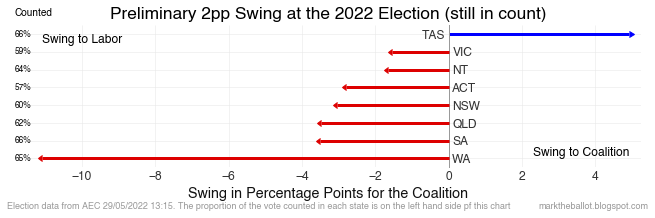

In [32]:
# marshall our data
data = houseTppByState['Swing']

# plot our data
ax, rightax, data, labels = set_up_swing_chart(houseTppByState['Swing'])
ax.figure.set_size_inches(9, 3)
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each state
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByState.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

# annotate axes
ax.text(data.min(), data.index.max(), 'Swing to Labor',
        ha='left', va='top', fontsize='large')
ax.text(data.max(), data.index.min(), 'Swing to Coalition',
        ha='right', va='bottom', fontsize='large')

common.plot_finalise(
    ax, 
    title='Preliminary 2pp Swing at the 2022 Election (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points for the Coalition', 
    lfooter=LFOOTER +
            'The proportion of the vote counted in each state is on the left hand side pf this chart', 
)

### State primary first preference swings

In [33]:
colours = {
    'Coalition': 'blue',
    'Labor': '#dd0000',
    'Green': 'green',
    'One Nation': 'darkorange',
    'UAP': 'gold',
    'Other': 'darkorchid',
}

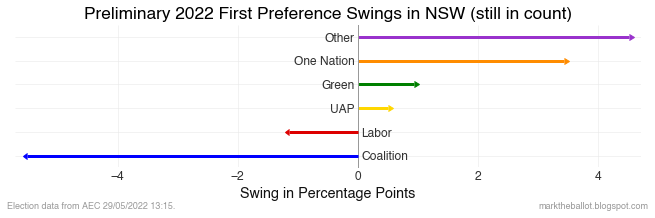

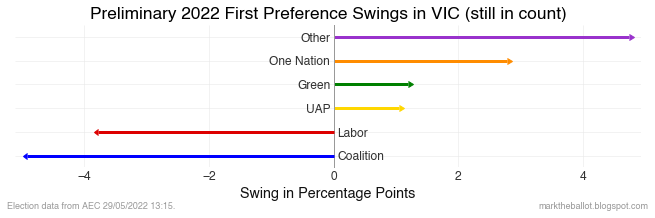

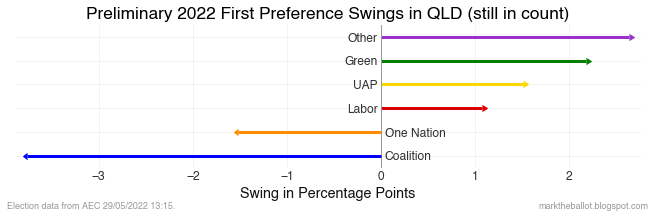

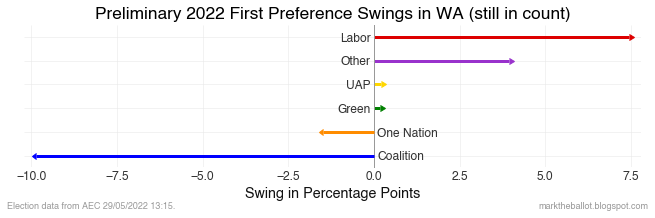

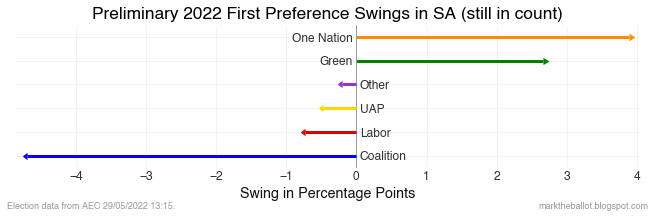

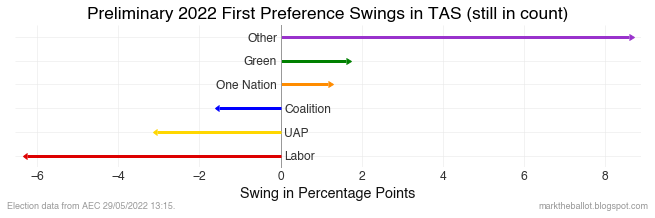

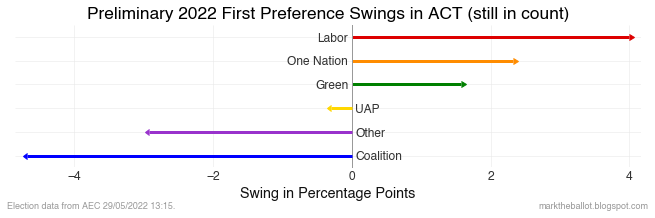

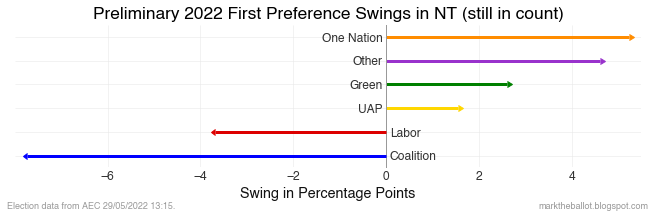

In [34]:
d22 = houseFirstPrefsByStateByParty2022
d19 = houseFirstPrefsByStateByParty2019

combined = {}
for state in d22['StateAb'].unique():

    # data marshalling 
    state2022 = d22[d22['StateAb'] == state].copy()
    state2019 = d19[d19['StateAb'] == state].copy()
    grouped2022 = get_group_totals(state2022)
    grouped2019 = get_group_totals(state2019)
    swings2022 = (grouped2022 - grouped2019).sort_values()
    for group, value in swings2022.iteritems():
        if group in combined:
            combined[group] = combined[group] | {state: value} # Python 3.10 feature
        else:
            combined[group] = {state: value}
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(swings2022)
    ax.figure.set_size_inches(9, 3)


    for x, y, l in zip(data, data.index, labels):
        ecolor = colours[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)

    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings in {state} (still in count)',
        ylabel=None,
        xlabel='Swing in Percentage Points', 
        lfooter=LFOOTER, 
    )    

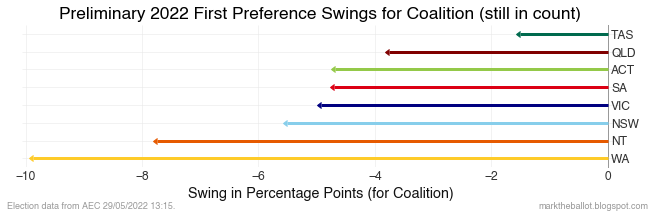

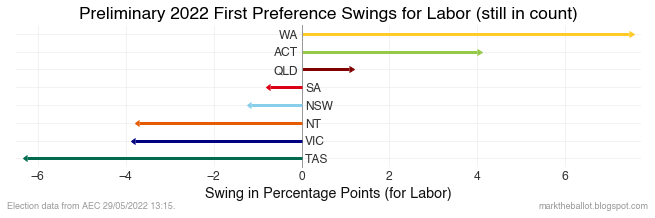

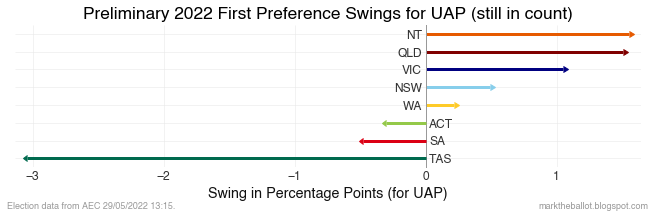

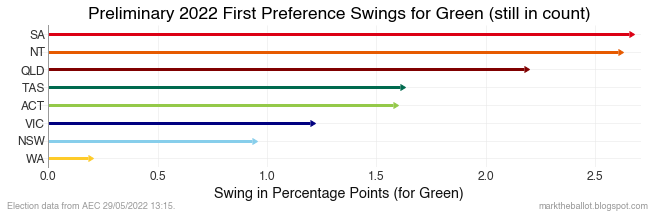

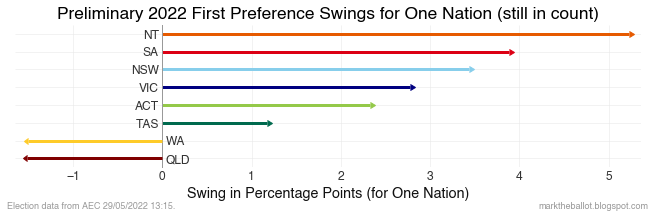

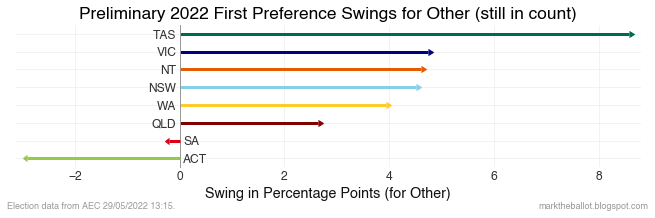

In [35]:
state_palette = {
    # colours from the R strayr package
    "NSW": '#87ceeb',
    "VIC": '#000080', 
    "QLD": '#800000', 
    "WA": '#fecb29', 
    "SA": '#dc0014', 
    "TAS": '#006a4e', 
    "ACT": '#94c949', 
    "NT": '#e65a00',
}

for group, dict_ in combined.items():
    
    # data
    series = pd.Series(dict_)
    
    # plot
    ax, rightax, data, labels = set_up_swing_chart(series)
    ax.figure.set_size_inches(9, 3)
    
    for x, y, l in zip(data, data.index, labels):
        ecolor = state_palette[l]
        if x >= 0:
            ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=ecolor)
        else:
            rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=ecolor)

    finalise_swing_chart(ax, rightax, data, labels)
    
    common.plot_finalise(
        ax, 
        title=f'Preliminary 2022 First Preference Swings for {group} (still in count)',
        ylabel=None,
        xlabel=f'Swing in Percentage Points (for {group})', 
        lfooter=LFOOTER, 
    )        


### Divisional 2pp swings

In [36]:
houseTppByDivision

,DivisionNm,DivisionID,StateAb,PartyAb,Liberal/National Coalition Votes,Liberal/National Coalition Percentage,Australian Labor Party Votes,Australian Labor Party Percentage,TotalVotes,Swing,Enrolment,Counted%
Adelaide (SA),Adelaide,179,SA,NaN,36176,38.18,58577,61.82,94753,-3.64,130151,72.802360
Aston (VIC),Aston,197,VIC,NaN,44883,53.18,39523,46.82,84406,-6.95,109826,76.854297
Ballarat (VIC),Ballarat,198,VIC,NaN,30160,36.82,51751,63.18,81911,-2.95,110704,73.991003
Banks (NSW),Banks,103,NSW,NaN,44144,53.68,38095,46.32,82239,-2.58,107786,76.298406
Barker (SA),Barker,180,SA,NaN,64014,66.76,31870,33.24,95884,-2.18,123518,77.627552
...,...,...,...,...,...,...,...,...,...,...,...,...
Werriwa (NSW),Werriwa,153,NSW,NaN,37463,44.84,46086,55.16,83549,0.31,126141,66.234610
Whitlam (NSW),Whitlam,150,NSW,NaN,40239,40.00,60350,60.00,100589,0.91,125535,80.128251
Wide Bay (QLD),Wide Bay,178,QLD,NaN,50870,61.59,31722,38.41,82592,-1.56,115420,71.557789
Wills (VIC),Wills,234,VIC,NaN,0,0.00,0,0.00,0,-24.29,108500,0.000000


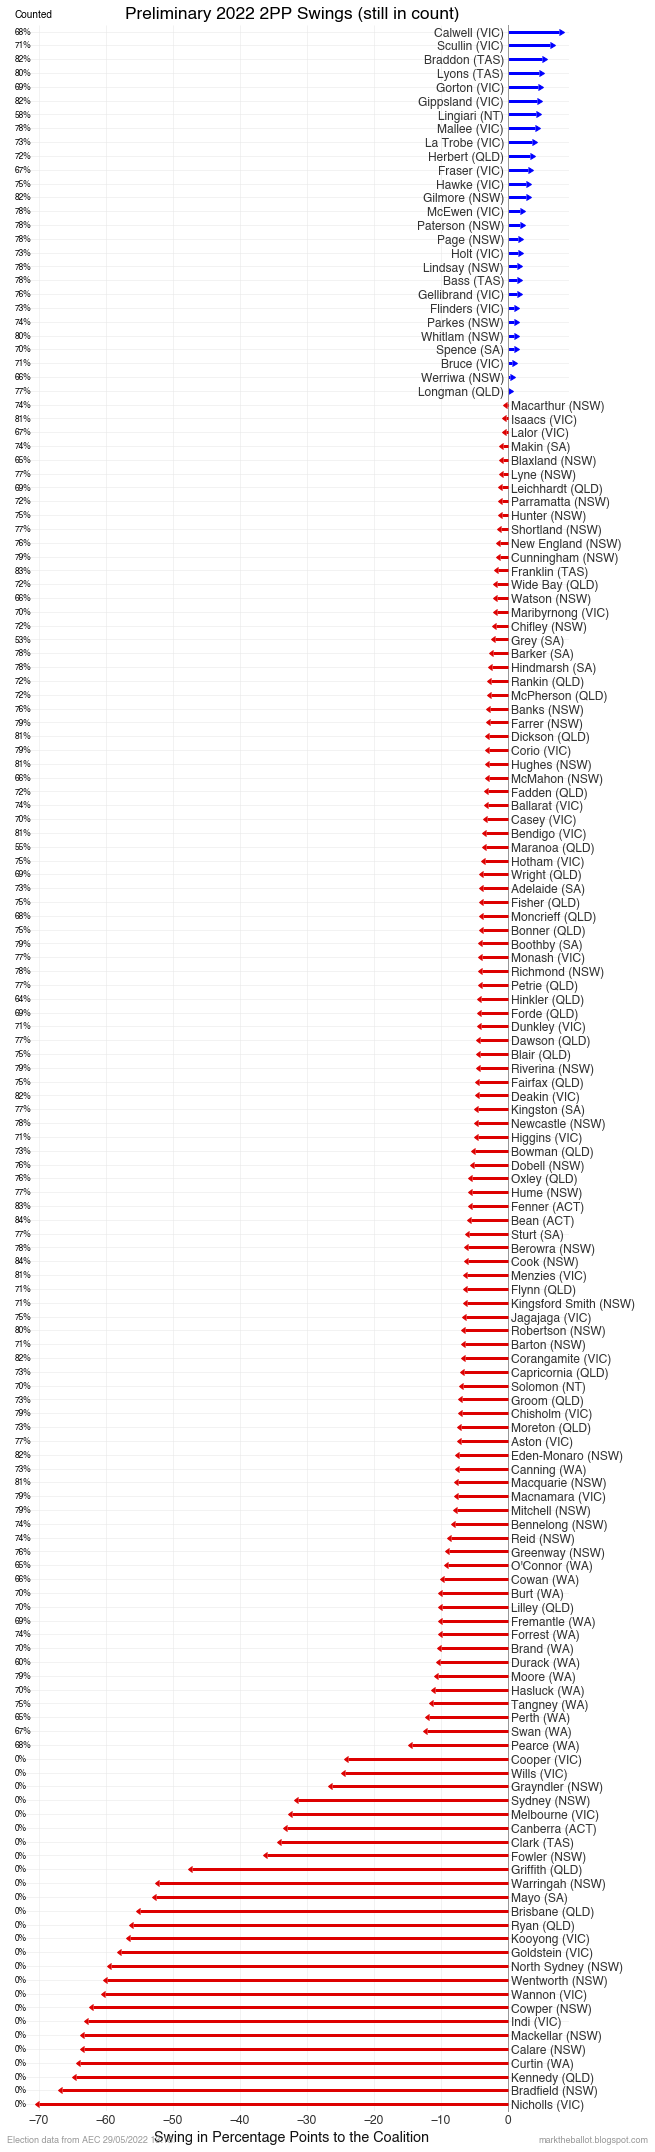

In [37]:
data = houseTppByDivision['Swing'].copy()
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9, 30)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')

finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{houseTppByDivision.at[label, "Counted%"]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Preliminary 2022 2PP Swings (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=LFOOTER, 
)    

### Green TCP swings

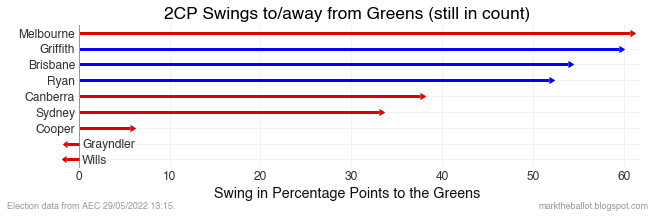

In [38]:
x_colors = {
    'ALP': '#dd0000',
    'Coalition': 'blue',
    'GRN': 'limegreen',
    'IND': 'darkorange'
}

GREEN = 'GRN'
orig_ = tcp_swings[tcp_swings[GREEN].notna()]
greens = orig_[GREEN]

ax, rightax, series, labels = set_up_swing_chart(greens)
ax.figure.set_size_inches(9, 3)

# plot our data
for x, y, label in zip(series, series.index, labels):
    kommen = orig_.drop(GREEN, axis=1).loc[label].idxmax()
    c = x_colors[kommen]
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor=c)
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor=c)
        
finalise_swing_chart(ax, rightax, series, labels)

common.plot_finalise(
    ax, 
    title=f'2CP Swings to/away from Greens (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Greens', 
    lfooter=LFOOTER, 
) 

### Traditional TCP swings

In [39]:
missing = tcp_swings.isna().all(axis=1)
missing_text = f'Missing from AEC feed: {(", ").join(missing[missing].index)}.' if missing.any() else ''
missing_text

''

In [40]:
TRADITIONAL = ['ALP', 'Coalition']
data = tcp_swings[tcp_swings[TRADITIONAL].notna().all(axis=1)]
data = data['Coalition']
data

DivisionNm
Adelaide   -3.64
Aston      -6.95
Ballarat   -2.95
Banks      -2.58
Barker     -2.18
            ... 
Watson     -1.61
Werriwa     0.31
Whitlam     0.91
Wide Bay   -1.56
Wright     -3.64
Name: Coalition, Length: 125, dtype: float64

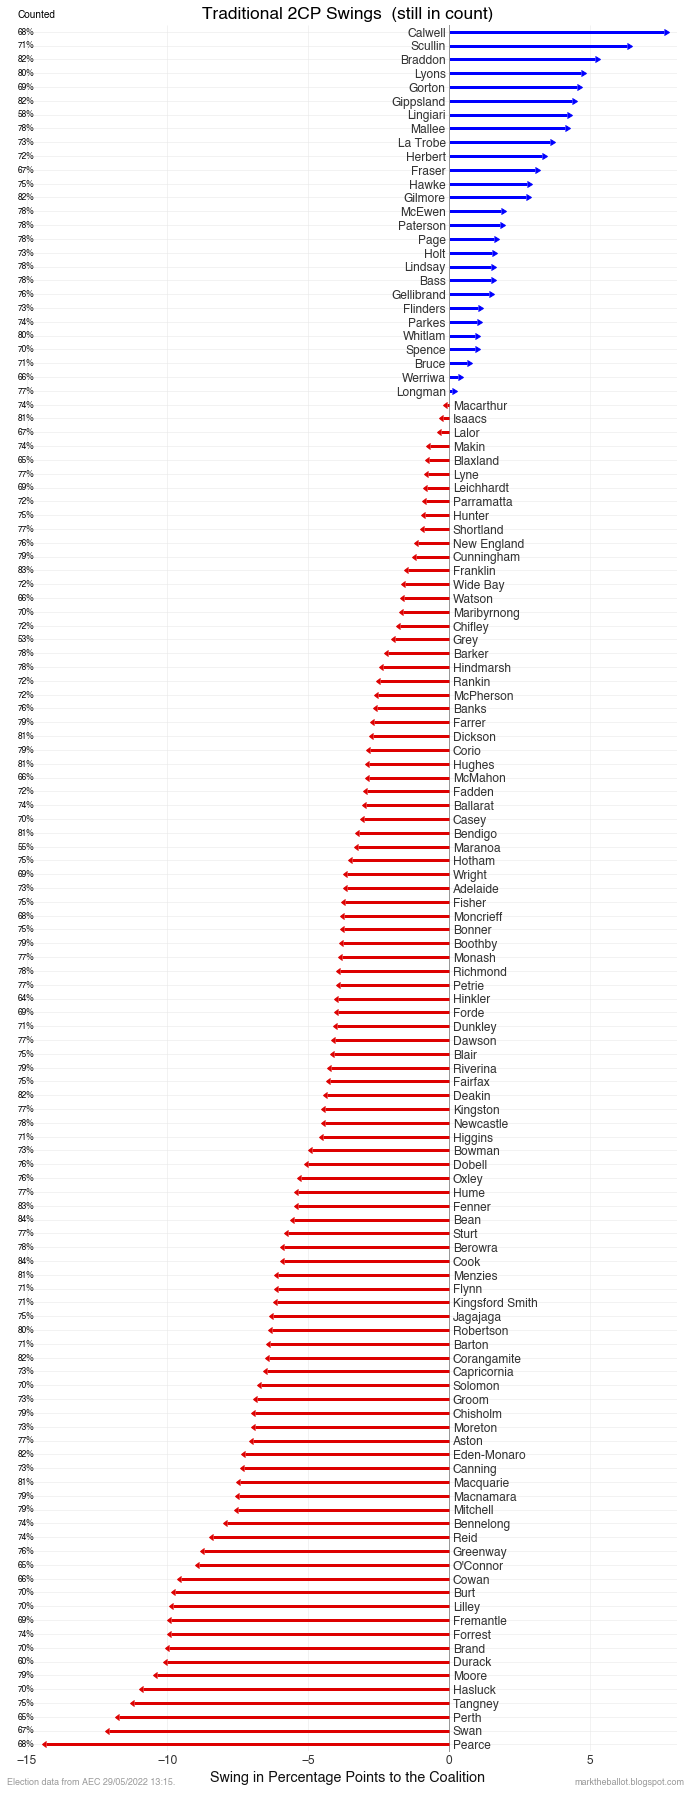

In [41]:
#data.index = [f'{a} {float(b):0.1f}' for a, b in zip(data.index, data)]
ax, rightax, data, labels = set_up_swing_chart(data)
ax.figure.set_size_inches(9.5, 25)
# plot our data
for x, y in zip(data, data.index):
    if x < 0:
        rightax.errorbar(0, y, xerr=-x, xuplims=True, lw=3, ecolor='#dd0000')
    else:
        ax.errorbar(0, y, xerr=x, xlolims=True, lw=3, ecolor='blue')
        
finalise_swing_chart(ax, rightax, data, labels)

# add in the count completion percentages for each division
xlim_lo, xlim_high = ax.get_xlim()
adj = (xlim_high - xlim_lo) * 0.025
ax.set_xlim(xlim_lo-adj, xlim_high)
for y, label in enumerate(labels):
    text = f'{cooked_tcp_counted[label]:0.0f}%'
    ax.text(xlim_lo - adj, y, text, ha='left', va='center', fontsize='small')
ax.text(xlim_lo - adj, y+1, 'Counted')

common.plot_finalise(
    ax, 
    title=f'Traditional 2CP Swings  (still in count)',
    ylabel=None,
    xlabel='Swing in Percentage Points to the Coalition', 
    lfooter=f'{LFOOTER}{missing_text}', 
)    

In [42]:
tcp_swings.loc['Brisbane']

PartyAb
ALP            NaN
GRN          53.85
IND            NaN
KAP            NaN
XEN            NaN
Coalition    46.15
Name: Brisbane, dtype: float64

## Seat allocations

### Tally Class

In [43]:
class Tally:
    
    """Maintain sets of won seats for each party.
       Initially all seats are UNALLOCATED. As seats are 
       allocated they are removed from the UNALLOCATED set,
       and put into the set for the nominated party outcome."""
    
    UNALLOCATED = 'Unallocated'
    STAR = '*' # a useful catch-all - elections can have 50 micro parties
    
    
    def __init__(self, seat_list: List[str]):
        """Create a Tally with seats from seat_list Initialise  
           with all seats from the seat_list in the 
           'Unallocated' category."""
        self.tally = {}
        self.tally[self.UNALLOCATED] = set(seat_list)
        self.block_list = []

        
    # --- allocation related methods
        
    def set_manual_block(self, block_list: List[str]) -> None:
        """Provide a list of seats that cannot be moved."""
        self.block_list = block_list

        
    def move(self, bundle: List[str], source:str, dest:str) -> None:
        """Move seats in bundle list from the source outcome category 
           to the destination outcome category. Create a tally for
           destination if one does not already exist. """
        if dest not in self.tally.keys():
            self.tally[dest] = set()
        moving = set(bundle).intersection(self.tally[source])
        moving.difference_update(self.block_list)
        self.tally[source].difference_update(moving)
        self.tally[dest].update(moving)

        
    def allocate_seats(self, seats:pd.Series, assignmap:Dict[str,str]):
        """Allocate seats that have been declared by the AEC.
           seats is a series, with the seat as an index and the 
           winning party as the series. Assignmap allows multiple
           parties in coalition to be mapped to the same tally."""
        for party in seats.unique():
            print(party)
            bundle = seats[seats == party].index.to_list()
            self.move(bundle, self.UNALLOCATED, assignmap[party])


    def _get_default(self, a_map:Dict[str, str]) -> str:
        return a_map.get(self.STAR, '???')
            
    def allocate_by_threshold(self, 
               vote_df: pd.DataFrame, # in whole percentgaes
               count_s: pd.Series,    # in whole percentages
               assignmap: Dict[str, str], 
               thresholds: Dict[float, float]):
        """Alocate seats to a party based on the highest vote for a seat,
           and how much of the vote has been counted in each seat. 
           Use the assignmap to allocate a party to a party-grouping in the tally."""
        default = self._get_default(assignmap) 
        for vote_t, count_t in thresholds.items():
            frame = vote_df.loc[(vote_df.max(axis=1) > vote_t)
                                & (count_s > count_t)]
            if not len(frame): 
                continue
            movers = frame.idxmax(axis=1)
            for party in movers.unique():
                bundle = movers[movers == party].index.to_list()
                self.move(bundle, self.UNALLOCATED, assignmap.get(party, default))
                
    
    # --- information methods 
            
    def check_allocations(self, tcp_percent: pd.DataFrame, a_map: Dict[str, str]):
        """Return a list of seat allocations that are inconsistent with the
           latest TCP count."""
        tally_dict = {}
        for outcome, seats in self.tally.items():
            for seat in seats:
                tally_dict[seat] = outcome
        tally_series = pd.Series(tally_dict).sort_index()
        tcp_result = tcp_percent.idxmax(axis=1).sort_index()
        default = self._get_default(a_map) 
        tcp_result = tcp_result.apply(lambda x: a_map.get(x, default))
        problematic = tally_series != tcp_result
        return problematic[problematic].index.to_list()

                
    def get_seat_list(self, outcome_cat: str)-> List[str]:
        """Return a python list of all seats in a tally category."""
        return sorted(self.tally[outcome_cat])
    
    
    def get_seat_stringlist(self, outcome_cat: str)-> str:
        """Return a comma separated list of seats in the 
           desired outcome strategy."""
        return ', '.join(self.get_seat_list(outcome_cat))
    
    
    def get_seat_count(self, outcome_cat: str)-> str:
        """Return the seat count for a specific outcome category."""
        return len(self.tally[outcome_cat])

    
    def get_seat_counts(self) -> pd.Series:
        """Return a Series of seat counts by tally category."""
        s = {}
        for outcome, seats in self.tally.items():
            s[outcome] = len(seats)
        return pd.Series(s)

            
    def print_all_results(self) -> None:
        """Print all tallies in long form."""
        for outcome in self.tally.keys():
            print(f'{outcome}: {self.get_seat_count(outcome)} - '
                  f'({self.get_seat_stringlist(outcome)})')

            
    def print_all_counts(self) -> None:
        """Print all tally counts."""
        for outcome in self.tally.keys():
            print(f'{outcome}: {self.get_seat_count(outcome)}')


### Get status of individual seats

In [44]:
def print_seat_status(k):
    print(k)
    print('% Primary Counted:', fp_count_pct[k])
    print('First preferences:\n', fp_vote_pct.loc[k].dropna())
    print('% TCP Counted:', cooked_tcp_counted[k])
    print('TCP:\n', raw_pct_tcp_votes.loc[k].dropna())
    print('=' * 20)    

### Thresholds for counting purposes

In [45]:
TCP_THRESH = {
    # Threshholds for moving a seat from unallocated ...
    # vote_threshold, count_threshold (%)
    50.1:             89.5,
    50.3:             84.5,
    50.4:             79.5,
    50.5:             75.0,
    50.75:            70.0,
    51.0:             65.0,
    51.5:             60.0,
    52.0:             50.0,
    55.0:             45.0,
    60.0:             40.0,
}

FP_THRESH = {
    # Vote, Count
    50.0: 50,
    45.0: 60, # think hard about this one 
}

seat_list = fp_by_div.index.to_list()

assign_map = {
    # Thresholds for assigning seat based on a column in 
    # a DataFrame (seats x party) and a set threshold
    
    # DataFrame Party, Outcome Category
    'Coalition': 'Coalition',
    'LP': 'Coalition',
    'LNP': 'Coalition',
    'CLP': 'Coalition',
    'NP': 'Coalition',
    'Labor': 'Labor',
    'ALP': 'Labor',
    'GRN': 'Green',
    'IND': 'Independent', 
    '*': 'Other',  # Use star for mopping up others ...
}

### Initialise tally - apply any manual blocks

In [46]:
MANUAL_BLOCK = []

tally = Tally(seat_list)
tally.set_manual_block(MANUAL_BLOCK)

### Do the declared seats

In [47]:
tally.allocate_seats(elected, assign_map)
tally.print_all_counts()

Unallocated: 151


### Ugly manual adjustments

In [48]:
# Brisbane and Macnamara were resolved through a 3-candidate-preferred count
# Note: not yet carried over to the 2CP count
# https://www.aec.gov.au/news/results-3cp.htm#:~:text=The%20AEC%20will%20conduct%20three,be%20determined%20with%20sufficient%20certainty.

# Linguiari has a low turnout - but most likely will stay Labor. 

ugly_seats = pd.Series(
    {'Brisbane': 'GRN', 'Lingiari': 'ALP', }
)
tally.allocate_seats(ugly_seats, assign_map)
tally.print_all_counts()

GRN
ALP
Unallocated: 149
Green: 1
Labor: 1


In [49]:
# Let's just print details on every seat we are moving manually
for seat in ugly_seats.keys():
    print_seat_status(seat)

Brisbane
% Primary Counted: 72.45869962711892
First preferences:
 PartyAb
AJP      1.79
ALP     27.50
GRN     26.76
LDP      1.53
LNP     38.56
ON       2.05
UAPP     1.81
Name: Brisbane, dtype: float64
% TCP Counted: 3.5882817927036674
TCP:
 PartyAb
GRN    53.849577
LNP    46.150423
Name: Brisbane, dtype: float64
Lingiari
% Primary Counted: 58.185010128291694
First preferences:
 PartyAb
ALP     37.07
CEC      1.09
CLP     34.85
GRN     10.73
IND      2.90
LDP      4.02
ON       5.31
UAPP     4.04
Name: Lingiari, dtype: float64
% TCP Counted: 58.185010128291694
TCP:
 PartyAb
ALP    51.276517
CLP    48.723483
Name: Lingiari, dtype: float64


### First Preferences

In [50]:
tally.allocate_by_threshold(fp_vote_pct, fp_count_pct, assign_map, 
                          FP_THRESH)
tally.get_seat_counts()

Unallocated    100
Green            2
Labor           23
Coalition       24
Independent      2
dtype: int64

### TCP counts

In [51]:
tally.allocate_by_threshold(cooked_pct_tcp_votes, cooked_tcp_counted, 
                          assign_map, TCP_THRESH)

house = tally.get_seat_counts().sort_values()
house

Unallocated     2
Other           2
Green           4
Independent    10
Coalition      57
Labor          76
dtype: int64

### State of play

In [52]:
tally.print_all_results() 

Unallocated: 2 - (Deakin, Gilmore)
Green: 4 - (Brisbane, Griffith, Melbourne, Ryan)
Labor: 76 - (Adelaide, Ballarat, Barton, Bean, Bendigo, Bennelong, Blair, Blaxland, Boothby, Brand, Bruce, Burt, Calwell, Canberra, Chifley, Chisholm, Cooper, Corangamite, Corio, Cowan, Cunningham, Dobell, Dunkley, Eden-Monaro, Fenner, Franklin, Fraser, Fremantle, Gellibrand, Gorton, Grayndler, Greenway, Hasluck, Hawke, Higgins, Hindmarsh, Holt, Hotham, Hunter, Isaacs, Jagajaga, Kingsford Smith, Kingston, Lalor, Lilley, Lingiari, Lyons, Macarthur, Macnamara, Macquarie, Makin, Maribyrnong, McEwen, McMahon, Moreton, Newcastle, Oxley, Parramatta, Paterson, Pearce, Perth, Rankin, Reid, Richmond, Robertson, Scullin, Shortland, Solomon, Spence, Swan, Sydney, Tangney, Watson, Werriwa, Whitlam, Wills)
Coalition: 57 - (Aston, Banks, Barker, Bass, Berowra, Bonner, Bowman, Braddon, Bradfield, Calare, Canning, Capricornia, Casey, Cook, Cowper, Dawson, Dickson, Durack, Fadden, Fairfax, Farrer, Fisher, Flinders, Flyn

### State of the House

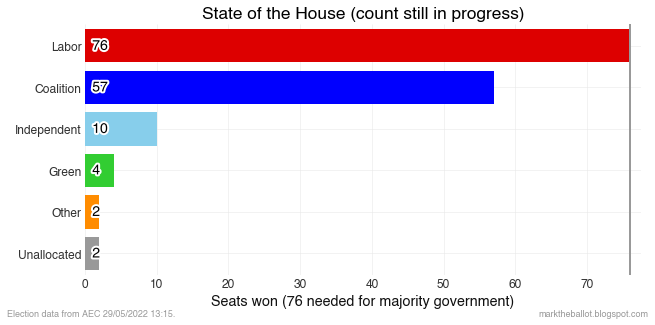

In [53]:
def plot_state_of_house(tally, title):
    
    cmap = {
        'Labor': '#dd0000',
        'Coalition': 'blue',
        'Independent': 'skyblue',
        'Unallocated': '#999999',
        'Green': 'limegreen',
        'Other': 'darkorange',
    }
    
    house = tally.get_seat_counts().sort_values()

    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    ax.axvline(76, c='#999999')
    for party, count in house.iteritems():
        if count <= 0:
            continue
        ax.barh(party, count, color=cmap[party])
        text = ax.text(1, party, f'{count}', ha='left', va='center', fontsize=14)
        text.set_path_effects([pe.withStroke(linewidth=4, foreground='w')])

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Seats won (76 needed for majority government)',
        lfooter=LFOOTER, 
    )
    
plot_state_of_house(tally, 'State of the House (count still in progress)')

### House outcome and closer seats

In [54]:
def get_close(close):
    close_tcp_votes = cooked_pct_tcp_votes.loc[close]
    max_value = close_tcp_votes.max(axis=1)
    max_label = close_tcp_votes.idxmax(axis=1)
    min_label = close_tcp_votes.idxmin(axis=1)
    return (
        pd.DataFrame({'Values': max_value.values, 
                      'Group': max_label.values, 
                      'Seat': close_tcp_votes.index },
                      index=[f'{seat} {a}-vs-{b}' 
                             for seat, a, b in zip(close_tcp_votes.index, max_label, min_label)],)
    ).sort_values('Values')


In [55]:
def plot_close(data:pd.DataFrame, title):
    
    fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    for x, y, c in zip(data['Values'], data.index, data['Group']):
        if math.isnan(x):
            x=50
        color = x_colors[c] if c in x_colors else 'white'
        ax.barh(y, x-50, left=50, color=color)

    # add in the count completion percentages for each division
    xlim_lo, xlim_high = ax.get_xlim()
    adj = (xlim_high - xlim_lo) * 0.025
    ax.set_xlim(xlim_lo, xlim_high+adj)
    for y, label in enumerate(data['Seat']):
        if math.isnan(x):
            continue
        text = f'{cooked_tcp_counted[label]:0.0f}%'
        ax.text(xlim_high+adj, y, text, ha='right', va='center', fontsize='small')
    ax.text(xlim_high+adj, y+0.5, 'Counted', ha='right', va='center', )

    common.plot_finalise(
        ax, 
        title=title,
        ylabel=None,
        xlabel='Per cent two-candidate-preferred vote share', 
        lfooter=LFOOTER, 
    )

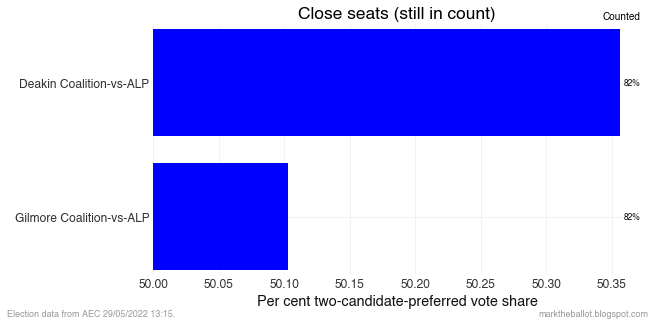

In [56]:
close = get_close(tally.get_seat_list(tally.UNALLOCATED))
if len(close):
    plot_close(close, 'Close seats (still in count)')

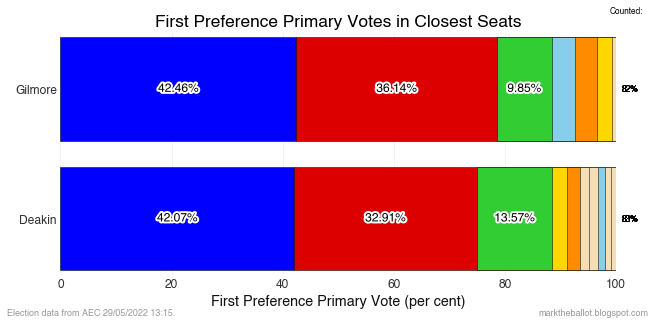

In [57]:
# Primaries for close counts
def plot_primaries(seats):
    seats = sorted(seats)
    
    colors = {
        'LP': 'blue',
        'LNP': 'blue',
        'CLP': 'blue',
        'NAT': 'darkgreen',
        'ALP': '#dd0000',
        'GRN': 'limegreen',
        'ON': 'darkorange',
        'IND': 'skyblue',
        'UAPP': 'gold',
        'JLN': 'hotpink',
        'Other': 'wheat',
    }
    fig, ax = fig, ax = common.initiate_plot()
    ax.figure.set_size_inches(9, 4.5)
    for seat in seats:
        primary = fp_vote_pct.loc[seat].dropna().sort_values(ascending=False)
        tally = 0.0
        for party, vote in primary.iteritems():
            color = colors['Other'] if party not in colors else colors[party]
            if tally == 0.0:
                ax.barh(seat, vote, color=color, edgecolor='black', linewidth=0.5)
            else:
                ax.barh(seat, tally+vote, left=tally, color=color, edgecolor='black', linewidth=0.5)
            if vote > 8:
                text = ax.text(tally+(vote/2), seat, f'{vote:0.2f}%', ha='center', va='center',
                    fontsize=12)
                text.set_path_effects([pe.withStroke(linewidth=4, foreground='w')])
            tally += vote
            count = f'{fp_count_pct[seat]:0.0f}%'
            ax.text(101, seat, count, ha='left', va='center', fontsize='small', fontweight='normal')
    ax.set_xlim((0, 100))
    ax.text(105, len(seats)-0.4, 'Counted:', ha='right', va='center', fontsize='small', )

    elements = []
    for party, color in colors.items():
        elements.append(Patch(facecolor=color, edgecolor='black', linewidth=0.5, label=party))
    #ax.legend(handles=elements, loc='best', ncol=len(elements),
    #          bbox_to_anchor=(0.96, 0), )
    
    common.plot_finalise(
        ax, 
        title='First Preference Primary Votes in Closest Seats',
        ylabel=None,
        xlabel='First Preference Primary Vote (per cent)', 
        lfooter=LFOOTER, 
    )
    
    
plot_primaries(tally.get_seat_list(tally.UNALLOCATED))

In [58]:
# Let's look in detail at the problematics ...


for k in tally.get_seat_list(tally.UNALLOCATED):
    print_seat_status(k)

Deakin
% Primary Counted: 82.99123360186164
First preferences:
 PartyAb
AJP      1.58
ALP     32.91
CYA      0.90
DHJP     1.06
GRN     13.57
IND      1.19
LDP      1.76
LP      42.07
ON       2.20
UAPP     2.74
Name: Deakin, dtype: float64
% TCP Counted: 81.6891525815133
TCP:
 PartyAb
ALP    49.643917
LP     50.356083
Name: Deakin, dtype: float64
Gilmore
% Primary Counted: 81.58292184773337
First preferences:
 PartyAb
ALP     36.14
GRN      9.85
IND      4.20
LDP      0.77
LP      42.46
ON       3.88
UAPP     2.69
Name: Gilmore, dtype: float64
% TCP Counted: 81.58292184773337
TCP:
 PartyAb
ALP    49.897366
LP     50.102634
Name: Gilmore, dtype: float64


### Hypothetically allocate remainders by hand

In [59]:
hypothetical = deepcopy(tally)
hypothetical.set_manual_block([])

In [60]:
# Allocate using the very latest TCP count
tcp_hypo_thresh = {
    # vote, thresh
    50.0: 0.1, 
}

hypothetical.allocate_by_threshold(cooked_pct_tcp_votes, 
                                   cooked_tcp_counted, 
                                   assign_map, 
                                   tcp_hypo_thresh)

In [61]:
# And we can move by hand if we really need to ...
if False:
    by_hand = {
        'Labor': ['Macnamara', 'Lingiari', 'Lyons', 'Bennelong', ],
        'Green': ['Brisbane', 'Ryan', ],
        'Coalition': ['Gilmore', 'Deakin', 'Wannon', ],
    }

    for dest, bundle in by_hand.items():
        hypothetical.move(bundle, tally.UNALLOCATED, dest)

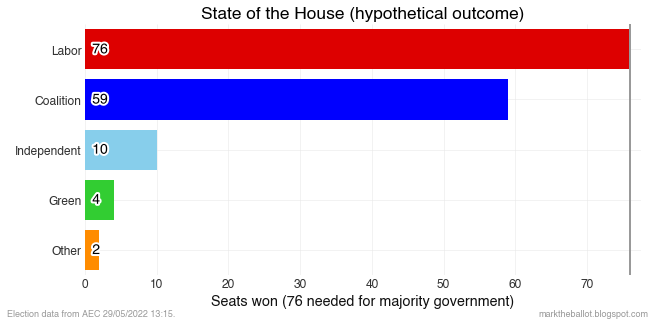

In [62]:
plot_state_of_house(hypothetical, 'State of the House (hypothetical outcome)')

In [63]:
# Check the hupothetical is consistent with the latest TCP counts ...
# If everything matches, there should be nothing to see here ...
l = hypothetical.check_allocations(cooked_pct_tcp_votes, assign_map)
if len(l):
    print(f'CAUTION: the hypothetical is inconsistent with the tally: {l}')

## The End

In [64]:
print('Done')

Done
